

**Machine Learning I (Semester 1 2025)**
# Tutorial Session 4: Model Selection & Regularization

*N. Hernitschek*



This Jupyter notebook gives an introduction to model selection and regularization for linear regression.

It is based on code from the textbook

*An Introduction to Statistical Learning: with Applications in Python.*
James Witten, Hastie, Tibshirani; Springer.

which is vailable for free as PDF: https://www.statlearning.com/


***Exercises required for class participation are in <font color='red'>red</font>.***

---
## Contents
* [Importing Packages](#first-bullet)
* [Best subset selection](#second-bullet)
* [Forward subset selection](#third-bullet)
* [The ridge and lasso method](#fourth-bullet)
* [Comparing models: AIC, BIC, $C_p$](#fifth-bullet)
* [Other methods in `sklearn`](#sixth-bullet)




## 1. Importing Packages <a class="anchor" id="first-bullet"></a>

We start with importing some of our libraries:

In [1]:
import itertools
import time
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

from ISLP import load_data


%matplotlib inline


### The dataset

The `credit` dataset is an example data set on which we will do linear regression. Some predictors are qualitative.

In [2]:
credit = load_data("Credit")
credit.columns


Index(['ID', 'Income', 'Limit', 'Rating', 'Cards', 'Age', 'Education',
       'Gender', 'Student', 'Married', 'Ethnicity', 'Balance'],
      dtype='object')

In [3]:
credit.head()

,ID,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
0,1,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
1,2,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
2,3,104.593,7075,514,4,71,11,Male,No,No,Asian,580
3,4,148.924,9504,681,3,36,11,Female,No,No,Asian,964
4,5,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331


### Encoding qualitative data
The `pandas` method `get_dummies` will encode the different strings we have as values in the columns into 0 and 1, where also "one-hot" encoding is possible.


example:

In [4]:
pd.get_dummies(pd.Series(list('abc')), dtype=float)

,a,b,c
0,1.0,0.0,0.0
1,0.0,1.0,0.0
2,0.0,0.0,1.0


In [5]:
pd.get_dummies(pd.Series(list('abc')), dtype=float, drop_first=True)

,b,c
0,0.0,0.0
1,1.0,0.0
2,0.0,1.0


The flag `drop_first` gives whether to get $k-1$ dummies out of $k$ categorical levels by removing the first level.


<font color='red'>Try this out</font>.


In [5]:
credit = pd.get_dummies(credit, columns = ['Gender', 'Student','Married','Ethnicity'],drop_first = True)
credit.head(30)


,ID,Income,Limit,Rating,Cards,Age,Education,Balance,Gender_Female,Student_Yes,Married_Yes,Ethnicity_Asian,Ethnicity_Caucasian
0,1,14.891,3606,283,2,34,11,333,False,False,True,False,True
1,2,106.025,6645,483,3,82,15,903,True,True,True,True,False
2,3,104.593,7075,514,4,71,11,580,False,False,False,True,False
3,4,148.924,9504,681,3,36,11,964,True,False,False,True,False
4,5,55.882,4897,357,2,68,16,331,False,False,True,False,True
5,6,80.180,8047,569,4,77,10,1151,False,False,False,False,True
6,7,20.996,3388,259,2,37,12,203,True,False,False,False,False
7,8,71.408,7114,512,2,87,9,872,False,False,False,True,False
8,9,15.125,3300,266,5,66,13,279,True,False,False,False,True
9,10,71.061,6819,491,3,41,19,1350,True,True,True,False,False


## 2. Best subset selection <a class="anchor" id="second-bullet"></a>


To perform best selection, we fit separate models for each possible combination of the $n$ predictors and then select the best subset. This means, we fit:

*    All models that contains exactly one predictor
*    All models that contain 2 predictors at the second step: $\binom{n}{2}$

...
Until reaching the end point where all $n$ predictors are included in the model.

This results in $2^n$ possibilities as this is a power set problem. In our case there are $2^{11} = 2048$ possible combinations



### Algorithm

Let $\mathscr{M}_0$ denote the null model which contains no predictors, this model simply predicts the sample mean of each observation

For $k=1,...,n$:
* Fit all $\binom{n}{k}$ models that contain exactly $k$ predictors
* Pick the best among these $\binom{n}{k}$ models, and call it $\mathscr{M}_k$ . Here the best is defined as having the smallest RSS, or an equivalent measure

Select the single best model among $\mathscr{M}_0, \mathscr{M}_1, ..., \mathscr{M}_k$ using cross validated predicton error, $C_p$, BIC, adjusted $R^2$ or any other method.


### Helper function for fitting linear regression (Sklearn)


In [6]:
def fit_linear_reg(X,Y):
    #Fit linear regression model and return RSS and R squared values
    model_k = linear_model.LinearRegression(fit_intercept = True)
    model_k.fit(X,Y)
    RSS = mean_squared_error(Y,model_k.predict(X)) * len(Y)
    R_squared = model_k.score(X,Y)
    return RSS, R_squared

### Implementing Best subset selection (using `itertools.combinations`)

The code below takes a while to run. This is why we display a progress bar.

In [7]:
#Importing tqdm for the progress bar
from tqdm import tnrange, tqdm_notebook

#Initialization variables
Y = credit.Balance
X = credit.drop(columns = 'Balance', axis = 1)
k = 11
RSS_list, R_squared_list, feature_list = [],[],[]
numb_features = []

#Looping over k = 1 to k = 11 features in X
for k in tnrange(1,len(X.columns) + 1, desc = 'Loop...'):

    #Looping over all possible combinations: from 11 choose k
    for combo in itertools.combinations(X.columns,k):
        tmp_result = fit_linear_reg(X[list(combo)],Y)   #Store temp result 
        RSS_list.append(tmp_result[0])                  #Append lists
        R_squared_list.append(tmp_result[1])
        feature_list.append(combo)
        numb_features.append(len(combo))   

#Store in DataFrame
df = pd.DataFrame({'numb_features': numb_features,'RSS': RSS_list, 'R_squared':R_squared_list,'features':feature_list})

/tmp/ipykernel_13970/3579709191.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for k in tnrange(1,len(X.columns) + 1, desc = 'Loop...'):


Loop...:   0%|          | 0/12 [00:00<?, ?it/s]

### Finding the best subsets for each number of features

We do so by using the smallest RSS value, or the largest $R^2$ value


In [8]:
df_min = df[df.groupby('numb_features')['RSS'].transform(min) == df['RSS']]
df_max = df[df.groupby('numb_features')['R_squared'].transform(max) == df['R_squared']]


#display(df)
display(df_min)
display(df_max)



/tmp/ipykernel_13970/4254293059.py:1: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  df_min = df[df.groupby('numb_features')['RSS'].transform(min) == df['RSS']]
/tmp/ipykernel_13970/4254293059.py:2: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  df_max = df[df.groupby('numb_features')['R_squared'].transform(max) == df['R_squared']]


,numb_features,RSS,R_squared,features
3,1,2.143512e+07,0.745848,"(Rating,)"
24,2,1.053254e+07,0.875118,"(Income, Rating)"
146,3,4.227219e+06,0.949879,"(Income, Rating, Student_Yes)"
474,4,3.915058e+06,0.953580,"(Income, Limit, Cards, Student_Yes)"
1126,5,3.866091e+06,0.954161,"(Income, Limit, Rating, Cards, Student_Yes)"
2049,6,3.821620e+06,0.954688,"(Income, Limit, Rating, Cards, Age, Student_Yes)"
2976,7,3.810759e+06,0.954817,"(Income, Limit, Rating, Cards, Age, Gender_Fem..."
3306,8,3.802227e+06,0.954918,"(ID, Income, Limit, Rating, Cards, Age, Gender..."
3807,9,3.795415e+06,0.954999,"(ID, Income, Limit, Rating, Cards, Age, Gender..."
4026,10,3.788550e+06,0.955080,"(ID, Income, Limit, Rating, Cards, Age, Gender..."


,numb_features,RSS,R_squared,features
3,1,2.143512e+07,0.745848,"(Rating,)"
24,2,1.053254e+07,0.875118,"(Income, Rating)"
146,3,4.227219e+06,0.949879,"(Income, Rating, Student_Yes)"
474,4,3.915058e+06,0.953580,"(Income, Limit, Cards, Student_Yes)"
1126,5,3.866091e+06,0.954161,"(Income, Limit, Rating, Cards, Student_Yes)"
2049,6,3.821620e+06,0.954688,"(Income, Limit, Rating, Cards, Age, Student_Yes)"
2976,7,3.810759e+06,0.954817,"(Income, Limit, Rating, Cards, Age, Gender_Fem..."
3306,8,3.802227e+06,0.954918,"(ID, Income, Limit, Rating, Cards, Age, Gender..."
3807,9,3.795415e+06,0.954999,"(ID, Income, Limit, Rating, Cards, Age, Gender..."
4026,10,3.788550e+06,0.955080,"(ID, Income, Limit, Rating, Cards, Age, Gender..."


### Adding columns to the dataframe with RSS and R squared values of the best subset


In [9]:
df['min_RSS'] = df.groupby('numb_features')['RSS'].transform(min)
df['max_R_squared'] = df.groupby('numb_features')['R_squared'].transform(max)
df.head()


/tmp/ipykernel_13970/2067500366.py:1: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  df['min_RSS'] = df.groupby('numb_features')['RSS'].transform(min)
/tmp/ipykernel_13970/2067500366.py:2: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  df['max_R_squared'] = df.groupby('numb_features')['R_squared'].transform(max)


,numb_features,RSS,R_squared,features,min_RSS,max_R_squared
0,1,8.433681e+07,0.000037,"(ID,)",2.143512e+07,0.745848
1,1,6.620874e+07,0.214977,"(Income,)",2.143512e+07,0.745848
2,1,2.171566e+07,0.742522,"(Limit,)",2.143512e+07,0.745848
3,1,2.143512e+07,0.745848,"(Rating,)",2.143512e+07,0.745848
4,1,8.370950e+07,0.007475,"(Cards,)",2.143512e+07,0.745848


### Plotting the best subset selection process


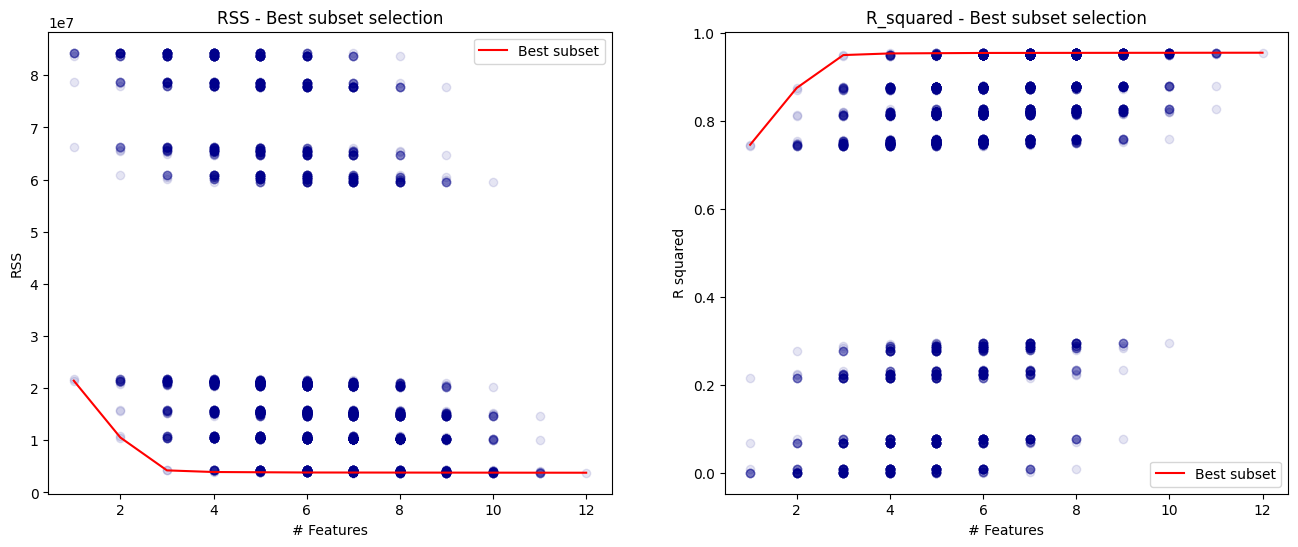

In [10]:
fig = plt.figure(figsize = (16,6))
ax = fig.add_subplot(1, 2, 1)

ax.scatter(df.numb_features,df.RSS, alpha=.1, color = 'darkblue' )
ax.set_xlabel('# Features')
ax.set_ylabel('RSS')
ax.set_title('RSS - Best subset selection')
ax.plot(df.numb_features,df.min_RSS,color = 'r', label = 'Best subset')
ax.legend()

ax = fig.add_subplot(1, 2, 2)
ax.scatter(df.numb_features,df.R_squared, alpha = .1, color = 'darkblue' )
ax.plot(df.numb_features,df.max_R_squared,color = 'r', label = 'Best subset')
ax.set_xlabel('# Features')
ax.set_ylabel('R squared')
ax.set_title('R_squared - Best subset selection')
ax.legend()

plt.show()


## 3. Forward subset selection <a class="anchor" id="third-bullet"></a>


For computational reasons, the best subset cannot be applied for any large $n$
due to the $2^n$ complexity. Forward Stepwise subset selection begins with a model containing no predictors, and then adds predictors to the model, one at the time. At each step, the variable that gives the greatest additional improvement to the fit is added to the model.


### Algorithm

Let $\mathscr{M}_0$ denote the null model which contains no predictors.

For $k=1,...,n-1$:


* Consider all $n−k$ models that augment the predictors in $\mathscr{M}_k$ with one additional predictor
* Choose the best among these $n-k$ models, and call it $\mathscr{M}_{k+1}$ .


Select the single best model among $\mathscr{M}_0, \mathscr{M}_1, ..., \mathscr{M}_n$ using cross validated predicton error, $C_p$, BIC, adjusted $R^2$ or any other method.


In [11]:
#Initialization variables
Y = credit.Balance
X = credit.drop(columns = 'Balance', axis = 1)
k = 11

remaining_features = list(X.columns.values)
features = []
RSS_list, R_squared_list = [np.inf], [np.inf] #Due to 1 indexing of the loop...
features_list = dict()

for i in range(1,k+1):
    best_RSS = np.inf
    
    for combo in itertools.combinations(remaining_features,1):

            RSS = fit_linear_reg(X[list(combo) + features],Y)   #Store temp result 

            if RSS[0] < best_RSS:
                best_RSS = RSS[0]
                best_R_squared = RSS[1] 
                best_feature = combo[0]

    #Updating variables for next loop
    features.append(best_feature)
    remaining_features.remove(best_feature)
    
    #Saving values for plotting
    RSS_list.append(best_RSS)
    R_squared_list.append(best_R_squared)
    features_list[i] = features.copy()

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


### Displaying results of the first 4 steps


In [12]:
print('Forward stepwise subset selection')
print('Number of features |', 'Features |', 'RSS')
display([(i,features_list[i], round(RSS_list[i])) for i in range(1,5)])

Forward stepwise subset selection
Number of features | Features | RSS


[(1, ['Rating'], 21435122),
 (2, ['Rating', 'Income'], 10532541),
 (3, ['Rating', 'Income', 'Student_Yes'], 4227219),
 (4, ['Rating', 'Income', 'Student_Yes', 'Limit'], 4032502)]

## 4. The ridge and lasso method  <a class="anchor" id="fourth"></a>

Within `sklearn`, there is also the ridge regression implemented (function `Ridge()`) as well as the lasso regression (function `Lasso()`) function. 

Multiple examples illustrating the usage can be found in the `sklearn` documentation:
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

We have seen that the ridge regression is basically minimizing a penalised version of the least-squared function:



Ridge regression is similar to least squares, except that the coefficients are estimated by minimizing a slightly different quantity. In particular, the ridge regression coefficient estimates $\hat{\beta}^R$ are the values that minimize

\begin{equation*}
\sum\limits^n_{i=1} \left( y_i-\beta_0 - \sum\limits^p_{j=1}\beta_j x_{ij}      \right)^2 + \lambda \sum\limits^p_{j=1}\beta_j^2 = RSS + \lambda \sum\limits^p_{j=1}\beta_j^2
\end{equation*}


The penalising shrinks the value of the regression coefficients. Despite the few data points in each dimension, the slope of the prediction is much more stable and the variance in the line itself is greatly reduced, in comparison to that of the standard linear regression

In the following example, we compare the outcome of the fit with least squares and ridge regression to the same dataset.

In [13]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn import linear_model

X_train = np.c_[0.5, 1].T
y_train = [0.5, 1]
X_test = np.c_[0, 2].T

print(X_train)

[[0.5]
 [1. ]]


[0.5, 1]
[[0]
 [2]]


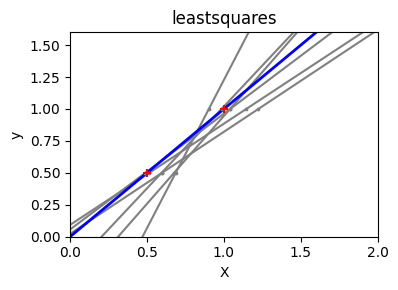

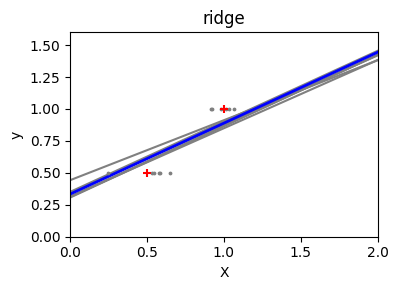

In [14]:
print(y_train)
print (X_test)

np.random.seed(0)

# note that the tuning parameter we called lambda is here named alpha
classifiers = dict(
    leastsquares=linear_model.LinearRegression(), ridge=linear_model.Ridge(alpha=0.1)
)

for name, clf in classifiers.items():
    fig, ax = plt.subplots(figsize=(4, 3))

    for _ in range(6):
        this_X = 0.1 * np.random.normal(size=(2, 1)) + X_train
        clf.fit(this_X, y_train)

        ax.plot(X_test, clf.predict(X_test), color="gray")
        ax.scatter(this_X, y_train, s=3, c="gray", marker="o", zorder=10)

    clf.fit(X_train, y_train)
    ax.plot(X_test, clf.predict(X_test), linewidth=2, color="blue")
    ax.scatter(X_train, y_train, s=30, c="red", marker="+", zorder=10)

    ax.set_title(name)
    ax.set_xlim(0, 2)
    ax.set_ylim((0, 1.6))
    ax.set_xlabel("X")
    ax.set_ylabel("y")

    fig.tight_layout()
    plt.show()

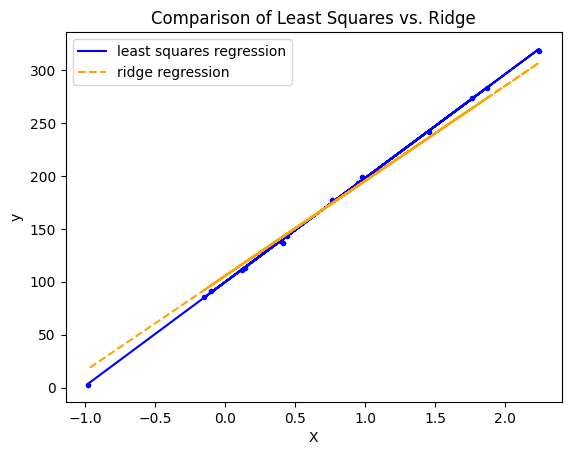

In [15]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import make_regression
from sklearn.linear_model import Ridge, LinearRegression


# Generate toy data.
rng = np.random.RandomState(0)
X, y = make_regression(
    n_samples=15, n_features=1, random_state=0, noise=2.0, bias=100.0
)

# Add some strong outliers to the dataset.
# X_outliers = rng.normal(0, 0.5, size=(4, 1))
# y_outliers = rng.normal(0, 2.0, size=4)
# X_outliers[:2, :] += X.max() + X.mean() / 4.0
# X_outliers[2:, :] += X.min() - X.mean() / 4.0
#y_outliers[:2] += y.min() - y.mean() / 4.0
#y_outliers[2:] += y.max() + y.mean() / 4.0
#X = np.vstack((X, X_outliers))
#y = np.concatenate((y, y_outliers))

plt.plot(X, y, "b.")

# Fit the huber regressor over a series of epsilon values.
colors = ["r-", "b-", "y-", "m-"]

# Fit a least squares regressor to compare it to huber regressor.
leastsquares = LinearRegression()
leastsquares.fit(X, y)
coef_leastsquares = leastsquares.coef_
coef_ = leastsquares.coef_ * X + leastsquares.intercept_
plt.plot(X, coef_, color="blue", label="least squares regression")


# Fit a ridge regressor to compare it to huber regressor.
ridge = Ridge(alpha=1.0, random_state=0) #the parameter that we called lambda is here called alpha
ridge.fit(X, y)
coef_ridge = ridge.coef_
coef_ = ridge.coef_ * X + ridge.intercept_
plt.plot(X, coef_, color="orange", linestyle='dashed',label="ridge regression")

plt.title("Comparison of Least Squares vs. Ridge")
plt.xlabel("X")
plt.ylabel("y")
plt.legend(loc=0)
plt.show()


## 5. Comparing models: AIC, BIC, $C_p$  <a class="anchor" id="fifth"></a>


The training set Mean Squared Error (MSE) is generally an underestimate of the test MSE. This is because when we fit a model to the training data using least squares, we specifically estimate the regression coefficients such that the training RSS is minimized. In particular, the training RSS decreases as we add more features to the model, but the test error may not. Therefore the training RSS and $R^2$ may not be used for selecting the best model unless we adjust for this underestimation.

### $C_p$



For a fitted least squares model containing $d$ predictors, the $C_p$ estimate 
of test MSE is computed using the equation

\begin{equation*}
C_p = \frac{1}{n}(\mathrm{RSS}+2d\hat{\sigma}^2)
\end{equation*}

where $\hat{\sigma}^2$ is an estimate of the variance of the error $\epsilon$ associated with each response measurement. Typically $\hat{\sigma}^2$ is estimated using the full model containing all predictors.


Typically $\hat{\sigma}^2$ is estimated using the full model containing all predictors.

Essentially,the $C_p$ statistic adds a penalty of $2d\hat{\sigma}^2$ to the training RSS in order to adjust for the fact that the training error tends to underestimate the test error. Clearly, the penalty increases as the number of predictors in the model increases, and this is intended to adjust for the corresponding decrease in training RSS. It can be shown that if $\hat{\sigma}^2$ is an unbiased estimate of $\sigma^2$ then $C_p$ is an unbiased estimate of the test MSE, so we choose the model with the smallest $C_p$.

### Akaike's Information Criteria (AIC)

The AIC criterion is defiend for a large class of models fit by maximum likelihood. In the case of a linear model with Gaussian errors, MLE and least squares are the same thing and the AIC is given by

\begin{equation*}
AIC = \frac{1}{n\hat{\sigma}^2}(\mathrm{RSS}+2d\hat{\sigma}^2)
\end{equation*}

### Bayesian Information Criteria (BIC)

BIC is derived from a Bayesian point of view, and looks similar to the $C_p$ and AIC - it is defined (up to irrelevant constants) as:


\begin{equation*}
BIC = \frac{1}{n\hat{\sigma}^2}(\mathrm{RSS}+\log(m)d\hat{\sigma}^2)
\end{equation*}

### Adjusted $R^2$
Since the $R^2$ always increases as more variables are added, the adjusted $R^2$ accounts for that fact and introduces a penalty. The intuition is that once all the correct variables have been included in the model, additional noise variables will lead to a very small decrase in RSS, but an increase in $k$ and hence will decrease the adjusted $R^2$. In effect, we pay a price for the inclusion of unnecessary variables in the model.



\begin{equation*}
R_a^2 = 1 - \frac{RSS/(n-k-1)}{TSS/(n-1)} = 1 - (1-R^2)\frac{n-k}{n-k-1}
\end{equation*}

### Estimation of $\hat{\sigma}^2$

Using the RSS of the full model with $p$ features, (i.e.the smallest RSS) we estimate $\hat{\sigma}^2$ as:\begin{equation*}
\hat{\sigma}^2 = \frac{RSS}{n-p-1}
\end{equation*}

### Combining forward stepwise results into a new DataFrame


In [16]:
df1 = pd.concat([pd.DataFrame({'features':features_list}),pd.DataFrame({'RSS':RSS_list, 'R_squared': R_squared_list})], axis=1, join='inner')
df1['numb_features'] = df1.index

In [17]:
print (df1)

                                             features           RSS  \
1                                            [Rating]  2.143512e+07   
2                                    [Rating, Income]  1.053254e+07   
3                       [Rating, Income, Student_Yes]  4.227219e+06   
4                [Rating, Income, Student_Yes, Limit]  4.032502e+06   
5         [Rating, Income, Student_Yes, Limit, Cards]  3.866091e+06   
6    [Rating, Income, Student_Yes, Limit, Cards, Age]  3.821620e+06   
7   [Rating, Income, Student_Yes, Limit, Cards, Ag...  3.810759e+06   
8   [Rating, Income, Student_Yes, Limit, Cards, Ag...  3.802227e+06   
9   [Rating, Income, Student_Yes, Limit, Cards, Ag...  3.795415e+06   
10  [Rating, Income, Student_Yes, Limit, Cards, Ag...  3.788550e+06   
11  [Rating, Income, Student_Yes, Limit, Cards, Ag...  3.782619e+06   

    R_squared  numb_features  
1    0.745848              1  
2    0.875118              2  
3    0.949879              3  
4    0.952188          

### Computing the $C_p$, AIC, BIC and $R^2$ adjusted


In [18]:
#Initializing useful variables
m = len(Y)
p = 11
hat_sigma_squared = (1/(m - p -1)) * min(df1['RSS'])

#Computing
df1['C_p'] = (1/m) * (df1['RSS'] + 2 * df1['numb_features'] * hat_sigma_squared )
df1['AIC'] = (1/(m*hat_sigma_squared)) * (df1['RSS'] + 2 * df1['numb_features'] * hat_sigma_squared )
df1['BIC'] = (1/(m*hat_sigma_squared)) * (df1['RSS'] +  np.log(m) * df1['numb_features'] * hat_sigma_squared )
df1['R_squared_adj'] = 1 - ( (1 - df1['R_squared'])*(m-1)/(m-df1['numb_features'] -1))
df1

,features,RSS,R_squared,numb_features,C_p,AIC,BIC,R_squared_adj
1,[Rating],2.143512e+07,0.745848,1,53636.550177,5.501738,5.511717,0.745210
2,"[Rating, Income]",1.053254e+07,0.875118,2,26428.843416,2.710923,2.730881,0.874489
3,"[Rating, Income, Student_Yes]",4.227219e+06,0.949879,3,10714.283563,1.099011,1.128947,0.949499
4,"[Rating, Income, Student_Yes, Limit]",4.032502e+06,0.952188,4,10276.234541,1.054079,1.093993,0.951703
5,"[Rating, Income, Student_Yes, Limit, Cards]",3.866091e+06,0.954161,5,9908.953491,1.016405,1.066298,0.953579
6,"[Rating, Income, Student_Yes, Limit, Cards, Age]",3.821620e+06,0.954688,6,9846.519746,1.010001,1.069873,0.953996
7,"[Rating, Income, Student_Yes, Limit, Cards, Ag...",3.810759e+06,0.954817,7,9868.112600,1.012216,1.082067,0.954010
8,"[Rating, Income, Student_Yes, Limit, Cards, Ag...",3.802227e+06,0.954918,8,9895.528903,1.015028,1.094857,0.953995
9,"[Rating, Income, Student_Yes, Limit, Cards, Ag...",3.795415e+06,0.954999,9,9927.242405,1.018281,1.108089,0.953960
10,"[Rating, Income, Student_Yes, Limit, Cards, Ag...",3.788550e+06,0.955080,10,9958.826469,1.021521,1.121307,0.953925


In [19]:

print(df1['R_squared_adj'].max())
print(df1['R_squared_adj'].idxmax())



0.9540098163629882
7


In [20]:
#df1['R_squared_adj'].idxmax()
#df1['R_squared_adj'].max()


df1['C_p'].max()

53636.55017718364

### Plotting the computed values as a function of number of features


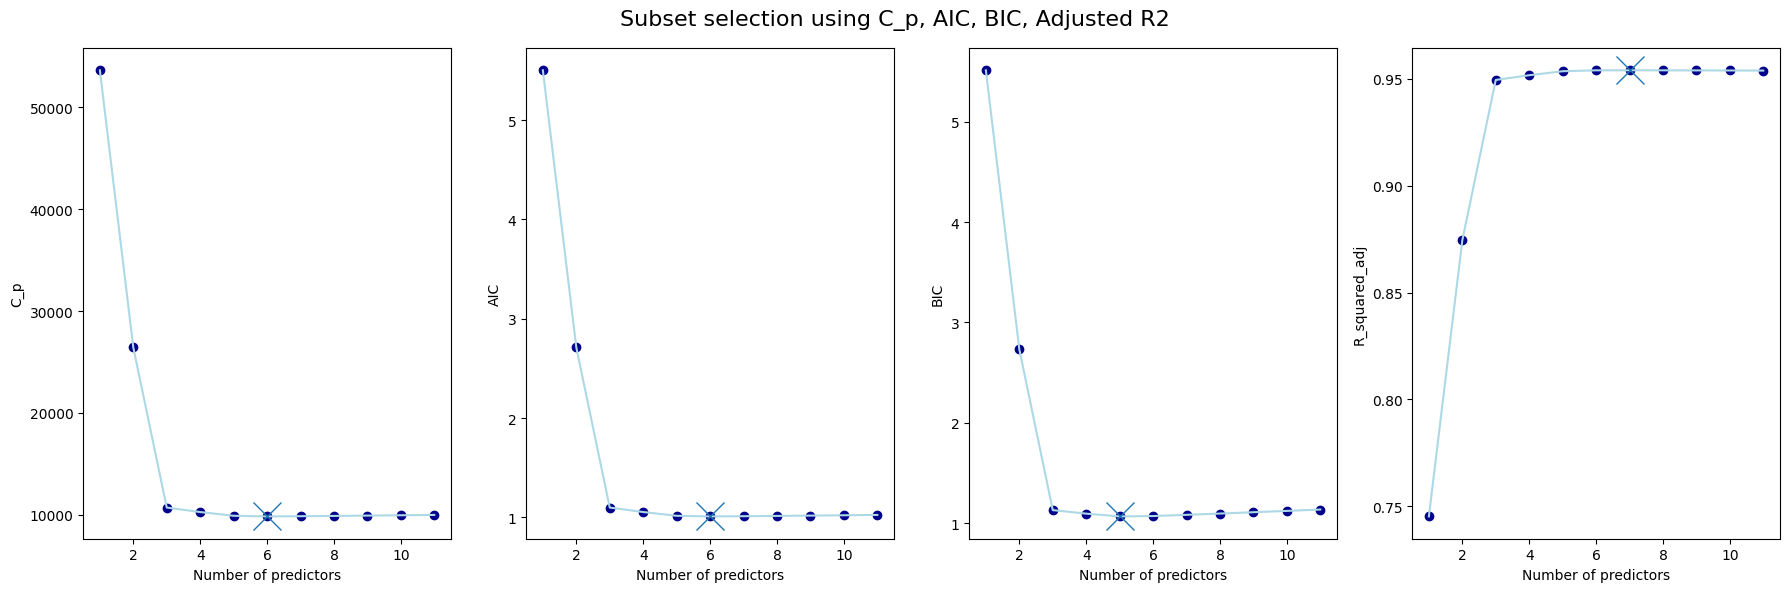

In [21]:
variables = ['C_p', 'AIC','BIC','R_squared_adj']
fig = plt.figure(figsize = (18,6))

for i,v in enumerate(variables):
    ax = fig.add_subplot(1, 4, i+1)
    ax.plot(df1['numb_features'],df1[v], color = 'lightblue')
    ax.scatter(df1['numb_features'],df1[v], color = 'darkblue')
    if v == 'R_squared_adj':
        ax.plot(df1[v].idxmax(),df1[v].max(), marker = 'x', markersize = 20)
    else:
        ax.plot(df1[v].idxmin(),df1[v].min(), marker = 'x', markersize = 20)
    ax.set_xlabel('Number of predictors')
    ax.set_ylabel(v)

fig.suptitle('Subset selection using C_p, AIC, BIC, Adjusted R2', fontsize = 16)
fig.tight_layout()
plt.show()


 <font color='red'>Based on the computed criteria, how would you decide? Which model with which predictors would you select?</font>

In base on the computed criteria I will decide the model base on the results for example for the $C_p$ the optimal will be the lowest whic is 9846.51, for the AIC the 1.010, BIC 1.066 and for $R^2$ 0.9538, so in base on that we have to select a balance between adjust and complexity so the model with 6 predictors ([Rating, Income, Student_Yes, Limit, Cards, Age]), as:
* It has the lowest value of Cₚ, AIC and BIC, indicating better expected performance on new data.
* The adjusted R2R2 value is almost equal to the maximum, with a simpler structure than the model with 7 predictors.
* It is a more parsimonious and efficient option.

## Summary <a class="anchor" id="fourth-bullet"></a>

At this point, all of you should have:
* seen how to prepare data for linear regression
*  seen how to apply linear regression in `sklearn`
*  implementing best subset and forward subset selection
* learned how to compare linear regression models.